In [1]:
import os

os.chdir("/mnt/c/users/rjmay/code")
print(os.getcwd())
# !source "venv/bin/activate"
!source env.sh

os.chdir("/mnt/c/users/rjmay/code/research_ms")
print(os.getcwd())

/mnt/c/users/rjmay/code
Environment for machine learning and research
/mnt/c/users/rjmay/code/research_ms


In [2]:
dpi = 250

In [3]:
# !pip list

In [4]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.spatial import distance
# from scipy.sparse.csgraph import minimum_spanning_tree
import math
import pickle
import time



## USING PREVIOUS DATA

We want to be able to save thing 

IF Pickled = True then we will previously simulated data using the pickle packge

In [5]:
PICKLED = True

##### set parent directory

In [6]:
# import os

# # Get the current working directory
# current_directory = os.getcwd()
# print("Current Directory:", current_directory)

# # Move to the parent directory
# parent_directory = os.path.dirname(current_directory)
# os.chdir(parent_directory)

# # Print the updated working directory
# updated_directory = os.getcwd()
# print("Updated Directory:", updated_directory)

### Simulation stage

In [7]:
from modules.multi_bounds_v3 import bounds_class
from modules.Bhatt_knn_func import knn_num_calc
from modules.data_gen_mv import data_gen_multivariate


In [8]:
mean_sep = np.linspace(0, 3, 15 , endpoint = True)

mean_sep = np.insert(mean_sep, 1, .1)
# mean_sep = np.linspace(.05, 3, 2 , endpoint = True)

mean_sep

array([0.        , 0.1       , 0.21428571, 0.42857143, 0.64285714,
       0.85714286, 1.07142857, 1.28571429, 1.5       , 1.71428571,
       1.92857143, 2.14285714, 2.35714286, 2.57142857, 2.78571429,
       3.        ])

In [9]:
bound_obj_lst = []
bound_obj_lst2 = []


if PICKLED: ## We just skip all the data creation if we are using save data. 
    print("USING PREVIOUS DATA NOT SIMULATING DATA ")
else:

    MC_num = 400
    sample_size= 500

    for i in mean_sep:

        start = time.time()
        dim =3 
        mean1 = np.zeros(dim)
        covariance1 = np.identity(dim)
        mean2 = np.zeros(dim)
        mean2[0] = i
        covariance2= np.identity(dim)
        
        func0 = np.random.multivariate_normal
        func1 = np.random.multivariate_normal


        params0 = {'mean': mean1, 'cov': covariance1}
        params1  = {'mean': mean2, 'cov': covariance2}

        generator = data_gen_multivariate(func0, func1,  params0, params1 )
        
        
        
        k = knn_num_calc(sample_size, len(mean1))


        bounds = bounds_class(generator, sample_size=  sample_size, threads =2,  MC_num = MC_num, k_nn=k)
        
        bound_obj_lst.append(bounds)

        
        print("done with 3d ", end = " ")
        dim = 8
        mean1 = np.zeros(dim)
        covariance1 = np.identity(dim)
        mean2 = np.zeros(dim)
        mean2[0] = i
        covariance2= np.identity(dim)

        
        
        params0  = {'mean': mean1, 'cov': covariance1}
        params1  = {'mean': mean2, 'cov': covariance2}

        generator = data_gen_multivariate(func0, func1,  params0, params1 )  
        
        k = knn_num_calc(sample_size, len(mean1))

        
        bounds2 = bounds_class(generator, sample_size = sample_size, threads =2,  MC_num = MC_num, k_nn =k )

        bound_obj_lst2.append(bounds2)
        
        
        end = time.time()
        
        print("done with ", i, " in ",  end -start )



USING PREVIOUS DATA NOT SIMULATING DATA 


##### Pickling
This is where the data either gets save or loaded

In [10]:
file_path = 'sim_data/means_sep_v3.pkl' # DONT FORGET TO CHANGE ME IF YOU COPY AND PASTE


if PICKLED  == False:
    
    objects_to_save = bound_obj_lst, bound_obj_lst2


    with open(file_path, 'wb') as file:
        # Use pickle.dump to serialize and write the list of objects to the file
        pickle.dump(objects_to_save, file)
    print(f'Objects saved to {file_path}')
    

elif PICKLED == True:
    

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    bound_obj_lst, bound_obj_lst2 = loaded_objects

Loaded object successfully


### Using the data

may or not be pickled. 

In [11]:
# bound_obj_lst[0].__uppper_bounds_Maha

In [12]:
import pandas as pd

df = pd.DataFrame([obj() for obj in bound_obj_lst], index = mean_sep)

# df

In [13]:
exact = []

for i in mean_sep:
    dx = 0.001
    x = np.arange(-5, 10 + dx, dx)

    f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
    f1 = np.exp(-0.5 * (x - i)**2) / np.sqrt(2 * np.pi)

    fmin = np.minimum(f0, f1)

    BER = 0.5 * np.sum(fmin * dx)
    
    exact.append(BER)

#     print("BER 2d:", BER)

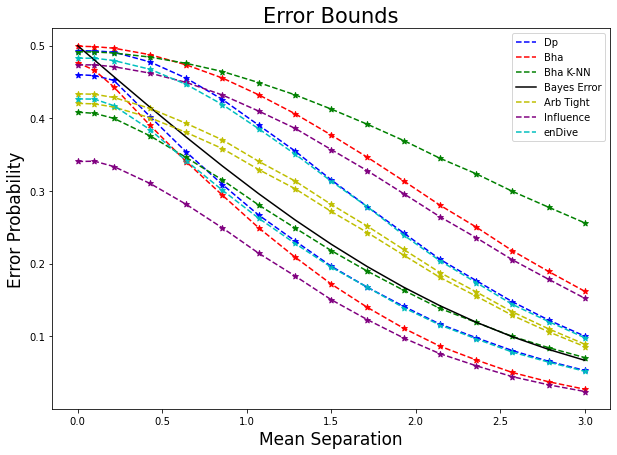

In [14]:
fs = 17

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))


# Plot Dp
ax.plot(df["Dp_lower"], 'b--', label='Dp')
ax.plot(df["Dp_upper"], 'b--')
ax.scatter(df.index, df["Dp_lower"], color='b', marker='*')
ax.scatter(df.index, df["Dp_upper"], color='b', marker='*')

# Plot Bha
ax.plot(df["Bha_lower"], 'r--', label='Bha')
ax.plot(df["Bha_upper"], 'r--')
ax.scatter(df.index, df["Bha_upper"], color='r', marker='*')
ax.scatter(df.index, df["Bha_lower"], color='r', marker='*')

# Plot Bha K-NN
ax.plot(df["Bha_knn_lower"], 'g--')
ax.plot(df["Bha_knn_upper"], 'g--', label='Bha K-NN')
ax.scatter(df.index, df["Bha_knn_upper"], color='g', marker='*')
ax.scatter(df.index, df["Bha_knn_lower"], color='g', marker='*')

# Plot Bayes Error
ax.plot(mean_sep, exact, 'k', label='Bayes Error')

# Plot Lower and Upper G_a
ax.plot(df["tight_lower"], 'y--', label="Arb Tight")
ax.plot(df["tight_upper"], 'y--')
ax.scatter(df.index, df["tight_lower"], color='y', marker='*')
ax.scatter(df.index, df["tight_upper"], color='y', marker='*')

# Plot Maha
# ax.plot( df["Maha_upper"], 'y--', label='Maha')
# ax.scatter(df.index, df["Maha_upper"], color='y', marker='*')

# Plot Lower and Upper G_a
ax.plot(df["inf_lower"], 'purple', linestyle = '--', label="Influence")
ax.plot(df["inf_upper"], 'purple', linestyle = '--')
ax.scatter(df.index, df["inf_lower"], color='purple', marker='*')
ax.scatter(df.index, df["inf_upper"], color='purple', marker='*')


# Plot Lower and Upper enDive
ax.plot(df["enDive_lower"], 'c', ls = '--', label="enDive")
ax.plot(df["enDive_upper"], 'c', ls = '--',)
ax.scatter(df.index, df["enDive_lower"], color='c', marker='*')
ax.scatter(df.index, df["enDive_upper"], color='c', marker='*')


ax.set_xlabel("Mean Separation", fontsize=fs)
ax.set_ylabel("Error Probability", fontsize=fs)
ax.set_title("Error Bounds", fontsize=fs + 4)
ax.legend()


file_name = r"images/mean-sep-plot3.png"
plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= 300)

plt.show()


In [15]:

# df

In [16]:
df = pd.DataFrame([obj() for obj in bound_obj_lst2], index = mean_sep)

# df


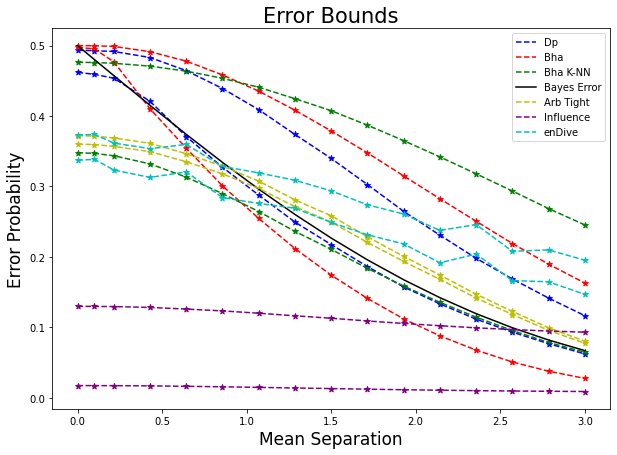

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))


# Plot Dp
ax.plot(df["Dp_lower"], 'b--', label='Dp')
ax.plot(df["Dp_upper"], 'b--')
ax.scatter(df.index, df["Dp_lower"], color='b', marker='*')
ax.scatter(df.index, df["Dp_upper"], color='b', marker='*')

# Plot Bha
ax.plot(df["Bha_lower"], 'r--', label='Bha')
ax.plot(df["Bha_upper"], 'r--')
ax.scatter(df.index, df["Bha_upper"], color='r', marker='*')
ax.scatter(df.index, df["Bha_lower"], color='r', marker='*')

# Plot Bha K-NN
ax.plot(df["Bha_knn_lower"], 'g--')
ax.plot(df["Bha_knn_upper"], 'g--', label='Bha K-NN')
ax.scatter(df.index, df["Bha_knn_upper"], color='g', marker='*')
ax.scatter(df.index, df["Bha_knn_lower"], color='g', marker='*')

# Plot Bayes Error
ax.plot(mean_sep, exact, 'k', label='Bayes Error')

# Plot Lower and Upper G_a
ax.plot(df["tight_lower"], 'y--', label="Arb Tight")
ax.plot(df["tight_upper"], 'y--')
ax.scatter(df.index, df["tight_lower"], color='y', marker='*')
ax.scatter(df.index, df["tight_upper"], color='y', marker='*')

# Plot Maha
# ax.plot( df["Maha_upper"], 'y--', label='Maha')
# ax.scatter(df.index, df["Maha_upper"], color='y', marker='*')

# Plot Lower and Upper G_a
ax.plot(df["inf_lower"], 'purple', linestyle = '--', label="Influence")
ax.plot(df["inf_upper"], 'purple', linestyle = '--')
ax.scatter(df.index, df["inf_lower"], color='purple', marker='*')
ax.scatter(df.index, df["inf_upper"], color='purple', marker='*')


# Plot Lower and Upper enDive
ax.plot(df["enDive_lower"], 'c', ls = '--', label="enDive")
ax.plot(df["enDive_upper"], 'c', ls = '--',)
ax.scatter(df.index, df["enDive_lower"], color='c', marker='*')
ax.scatter(df.index, df["enDive_upper"], color='c', marker='*')


ax.set_xlabel("Mean Separation", fontsize=fs)
ax.set_ylabel("Error Probability", fontsize=fs)
ax.set_title("Error Bounds", fontsize=fs + 4)
ax.legend()

file_name = r"Images/mean-sep-plot8.png"
plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= dpi)

plt.show()
